# Bitcoin Time Series Forecasting - Part Two: Neural Network Regression

## Introduction

In the second part of the project I attempt one-step ahead forecasts of the Bitcoin time series using a multilayer perception as a regressor. The Bitcoin time series can clearly been seen to nonstationary. In the hope of improving forecasts I therefore remove the stationarity with first differencing and then use the MLP to also regress on the time series of returns.

## Data Loading and Analysis

Loading some of the needed packages.

In [1546]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import matplotlib.pylab as plt
import seaborn as sns
sns.despine()
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import normaltest
from statsmodels.tsa.stattools import adfuller



from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

<Figure size 432x288 with 0 Axes>

Loading the keras package modules needed to build the neural network and assess its performance.

In [1547]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras import regularizers

 Reading in the data into pandas dataframe.

In [1548]:
#data are upside down
data = pd.read_csv('c:\\users\jamil\AnacondaProjects\Mariani_Prado\Kraken_BTCUSD_1h.csv', index_col= 0)
data.head()

,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
Date,,,,,,,
2019-06-28 01-AM,BTCUSD,11468.6,11533.0,11200.9,11478.4,365.78,4184793.31
2019-06-28 12-AM,BTCUSD,11148.0,11468.6,11002.6,11468.6,814.75,9215735.83
2019-06-27 11-PM,BTCUSD,11089.4,11335.0,10905.9,11148.0,971.72,10836698.04
2019-06-27 10-PM,BTCUSD,10729.0,11144.0,10665.6,11089.4,896.88,9785079.35
2019-06-27 09-PM,BTCUSD,10678.8,10837.1,10456.4,10729.0,672.38,7177959.51


In [1549]:
data.index = pd.to_datetime(data.index, format='%Y-%m-%d %I-%p')
data.head(10)

,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
Date,,,,,,,
2019-06-28 01:00:00,BTCUSD,11468.6,11533.0,11200.9,11478.4,365.78,4184793.31
2019-06-28 00:00:00,BTCUSD,11148.0,11468.6,11002.6,11468.6,814.75,9215735.83
2019-06-27 23:00:00,BTCUSD,11089.4,11335.0,10905.9,11148.0,971.72,10836698.04
2019-06-27 22:00:00,BTCUSD,10729.0,11144.0,10665.6,11089.4,896.88,9785079.35
2019-06-27 21:00:00,BTCUSD,10678.8,10837.1,10456.4,10729.0,672.38,7177959.51
2019-06-27 20:00:00,BTCUSD,10830.9,10899.8,10300.0,10678.8,1489.22,15715577.13
2019-06-27 19:00:00,BTCUSD,10995.4,10995.4,10520.4,10830.9,1191.77,12846614.99
2019-06-27 18:00:00,BTCUSD,10805.5,11097.5,10638.6,10995.4,971.41,10603374.74
2019-06-27 17:00:00,BTCUSD,10887.6,10920.0,10355.2,10805.5,2331.37,24900968.86


The data are in the reverse order for some reason. This needs to be corrected.

In [1550]:
data=data.reindex(index=data.index[::-1])
data.head()

,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
Date,,,,,,,
2017-07-01 11:00:00,BTCUSD,2491.97,2494.93,2483.32,2494.87,163.92,407837.90
2017-07-01 12:00:00,BTCUSD,2494.87,2494.87,2470.86,2477.97,80.93,200771.78
2017-07-01 13:00:00,BTCUSD,2477.97,2478.96,2444.44,2444.44,168.69,415839.42
2017-07-01 14:00:00,BTCUSD,2444.44,2463.60,2437.26,2448.99,119.59,292801.90
2017-07-01 15:00:00,BTCUSD,2448.99,2465.95,2438.99,2457.84,109.53,268333.15


Extracting the daily closing prices.

In [1551]:
data = (data['Close'])

In [1552]:
data.head()

Date
2017-07-01 11:00:00    2494.87
2017-07-01 12:00:00    2477.97
2017-07-01 13:00:00    2444.44
2017-07-01 14:00:00    2448.99
2017-07-01 15:00:00    2457.84
Name: Close, dtype: float64

Plotting the closing price series.

<AxesSubplot:xlabel='Date'>

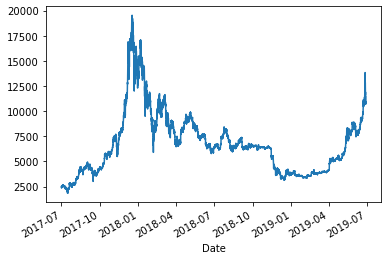

In [1553]:
data.plot()

The price time series seems consist of several different regions dominated by a trend and smaller stochastic component superimposed on it.

Generating a month-based box plot of the time seres:

C:\Users\jamil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Close'>

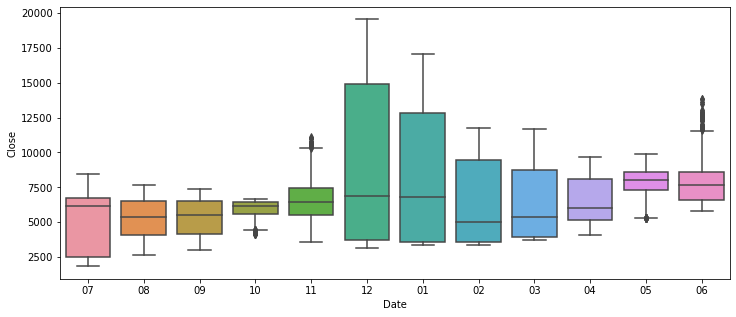

In [1554]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(data.index.to_series().apply(lambda x: x.strftime('%m')), data, ax=ax)

The boxplot illustrates the nonstationairies of the price time series. Applying the augmented Dickey-Fuller test for stationarity:

In [1555]:
result = adfuller(data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.649257
p-value: 0.457428
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


The null hypothesis of a nonstationary time series is accepted.

<AxesSubplot:ylabel='Frequency'>

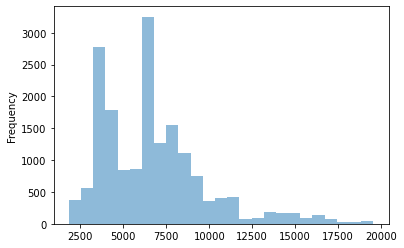

In [1556]:
data.plot.hist(bins=25, alpha=0.5)

The distribution of the values of the raw time series is obviously not Gaussian.

In [1557]:
stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=3526.430, p=0.000
Sample does not look Gaussian (reject H0)


The nonGaussainty is confirmed by the applicaton of the D'Agostini $K^2$ test.

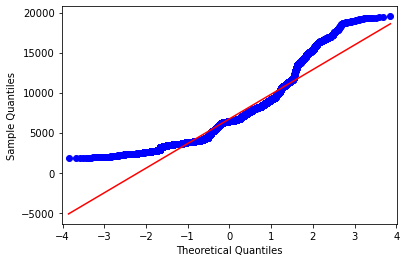

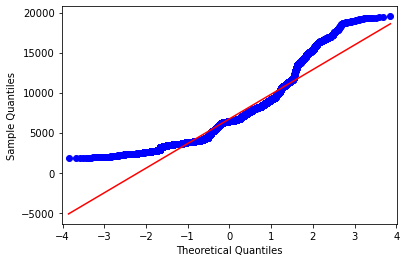

In [1558]:
from statsmodels.graphics.gofplots import qqplot
qqplot(data, line='s')

The autocorrelation function of the price time series looks more like one of a determinstic time series than a stochastic one.

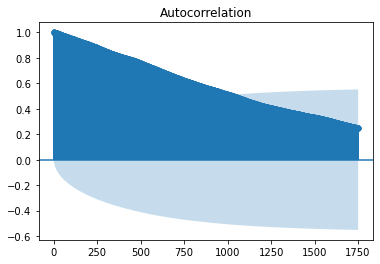

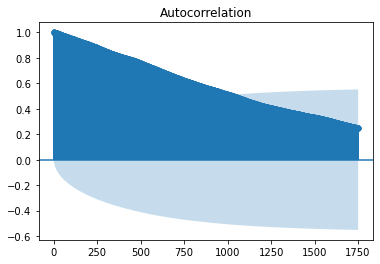

In [1559]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(data, lags=1750)

### Data Analysis of the Returns Time Series

Now taking the first difference of the raw Bitcoin time series to generate a stationary time series

In [1560]:
shiftdata = data.shift(1)

<AxesSubplot:xlabel='Date'>

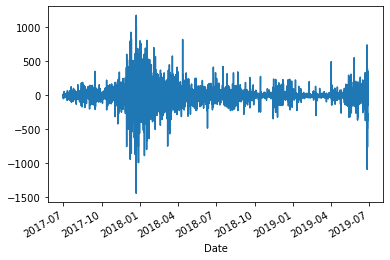

In [1561]:
diff = data - shiftdata
diff.dropna()
diff.plot()

The trends in all the regions of the price time series have been removed by the first differencing but the variance seems to be still nonstarionary. This is corrobrated by a boxplot of the returns time series.

In [1562]:
len(diff)

17439

C:\Users\jamil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Close'>

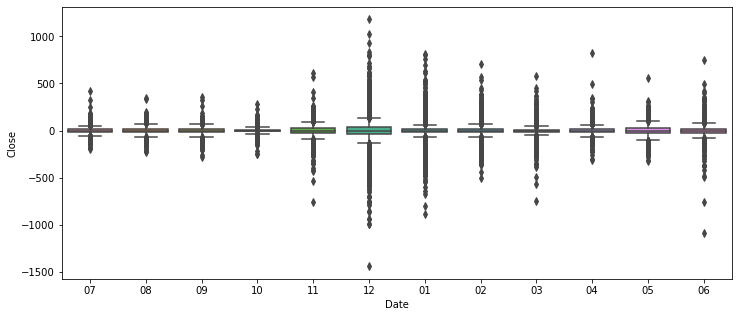

In [1563]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(diff.index.to_series().apply(lambda x: x.strftime('%m')), diff, ax=ax)

In [1564]:
diff.head()

Date
2017-07-01 11:00:00      NaN
2017-07-01 12:00:00   -16.90
2017-07-01 13:00:00   -33.53
2017-07-01 14:00:00     4.55
2017-07-01 15:00:00     8.85
Name: Close, dtype: float64

Removing NaN values from the time series

In [1565]:
diff = diff.dropna()

In [1566]:
diff.head()

Date
2017-07-01 12:00:00   -16.90
2017-07-01 13:00:00   -33.53
2017-07-01 14:00:00     4.55
2017-07-01 15:00:00     8.85
2017-07-01 16:00:00    -1.39
Name: Close, dtype: float64

In [1568]:
result = adfuller(diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.372550
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


We reject the null hypothesis of a nonstationarity time series but this is a unit-root test that only detects the prescence of trends not time varying variances. We can clearly see the variance is not constant.

The time series of returns now has a unimodal histogram but is still far from Gaussian.

<AxesSubplot:ylabel='Frequency'>

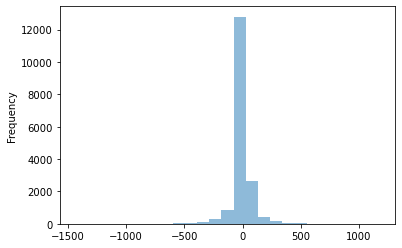

In [1569]:
diff.plot.hist(bins=25, alpha=0.5)

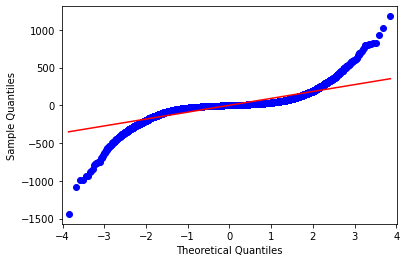

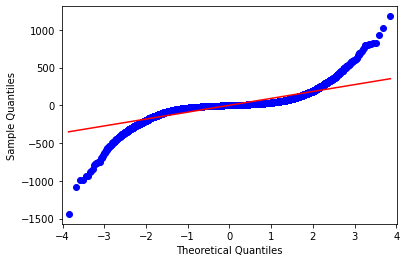

In [1570]:
qqplot(diff, line='s')

In [1571]:
stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')


Statistics=3526.430, p=0.000
Sample does not look Gaussian (reject H0)


Aplying the D'Agostoni $K^2$ test confirms its nonGaussanity.

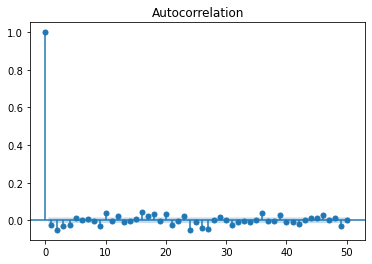

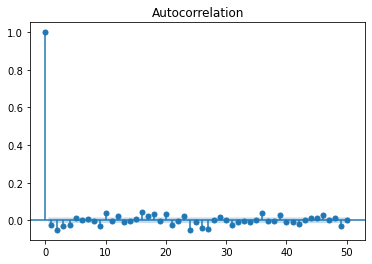

In [1572]:
sm.graphics.tsa.plot_acf(diff, lags=50)

It seems as though all correlaton has been removed by the first differencing operation. This bodes ill for forecasting.

## Neural Network Forecasting 

I now train a neural network to model and carry out one-step ahead predictions of the raw and the first differenced Bitcoin data.

## Neural Network Modelliing of the Raw Data

In [1573]:
data.head()

Date
2017-07-01 11:00:00    2494.87
2017-07-01 12:00:00    2477.97
2017-07-01 13:00:00    2444.44
2017-07-01 14:00:00    2448.99
2017-07-01 15:00:00    2457.84
Name: Close, dtype: float64

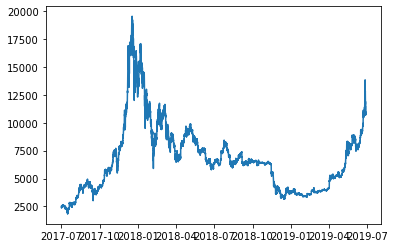

In [1574]:
plt.plot(data)

Preparing the time series data for supervising learning of a neural network.

In [1576]:
WINDOW = 31 # WINDOW has a different meaning in this notebook - it is the length of the data window + the predicted label
STEP = 1
FORECAST = 1

In [1577]:
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values



Extract the training and test data for the supervised learning algorithm.

In [1578]:
data2 = series_to_supervised(data, WINDOW)
X= data2[:,:WINDOW-1]

print(X)
print(X.shape)

[[ 2494.87  2477.97  2444.44 ...  2406.26  2433.    2448.  ]
 [ 2477.97  2444.44  2448.99 ...  2433.    2448.    2470.01]
 [ 2444.44  2448.99  2457.84 ...  2448.    2470.01  2475.  ]
 ...
 [13580.   13456.4  13800.   ... 10830.9  10678.8  10729.  ]
 [13456.4  13800.   13839.   ... 10678.8  10729.   11089.4 ]
 [13800.   13839.   12751.3  ... 10729.   11089.4  11148.  ]]
(17408, 30)


Extract the labels for the supervised learing algorithm.

In [1579]:
Y= data2[:,WINDOW]
Y= Y[:,None]
print(Y)
print(Y.shape)

[[ 2475.  ]
 [ 2482.94]
 [ 2488.59]
 ...
 [11148.  ]
 [11468.6 ]
 [11478.4 ]]
(17408, 1)


In [1580]:
import numpy.ma as ma

In [1581]:
X = np.where(np.isnan(X), ma.array(X, mask=np.isnan(X)).mean(axis=0), X)

In [1582]:
Y = np.where(np.isnan(Y), ma.array(Y, mask=np.isnan(Y)).mean(axis=0), Y)

Seperate the training and test data.

In [1583]:
train_X = X[:int((len(X)+1)*.66)] 
test_X = X[int(len(X)*.66+1):] 

In [1584]:
len(train_X)

11489

In [1585]:
len(test_X)

5918

Seperate the labels for the supervised learning algorithm.

In [1586]:
train_Y = Y[:int((len(Y)+1)*.66)] 
test_Y = Y[int(len(Y)*.66+1):] 

In [1587]:
len(test_Y)

5918

In [1588]:
len(train_Y)

11489

In order to obtain convergence with an optimizer it is necessary to normalise neural network training data. The scalar is obtained only from the training data and then applied to the test data in order to avoid data leakage.

Fit the scaler on the training data


In [1589]:
#norm = MinMaxScaler().fit(train_X)
norm = StandardScaler().fit(train_X)

Transform training data and the test data.


In [1590]:
X_train = norm.transform(train_X)

X_test = norm.transform(test_X)

In [1591]:
Y_train = train_Y
Y_test =  test_Y

In [1592]:
X_train.shape, X_test.shape
X_train

array([[-1.53642481, -1.54186412, -1.55240828, ..., -1.5707812 ,
        -1.56282408, -1.55847485],
       [-1.54160896, -1.5521506 , -1.55101228, ..., -1.56255606,
        -1.55820965, -1.55170326],
       [-1.55189444, -1.55075473, -1.54829697, ..., -1.55794211,
        -1.55143875, -1.55016804],
       ...,
       [-0.33473589, -0.33496504, -0.34099366, ..., -0.32364878,
        -0.33089593, -0.3311904 ],
       [-0.33482791, -0.3408553 , -0.33758802, ..., -0.33075427,
        -0.33104975, -0.33337478],
       [-0.3407176 , -0.33744999, -0.33823233, ..., -0.33090807,
        -0.33323391, -0.33312866]])

In [1593]:
X_test

array([[-0.33795681, -0.3384317 , -0.33939823, ..., -0.33284593,
        -0.33360306, -0.33192878],
       [-0.33829424, -0.33926002, -0.33884596, ..., -0.33346112,
        -0.33178806, -0.33494385],
       [-0.33912247, -0.33870781, -0.34378568, ..., -0.3316463 ,
        -0.33480281, -0.33112887],
       ...,
       [ 1.8639877 ,  1.82614707,  1.93164368, ...,  1.02061037,
         0.97381706,  0.98925334],
       [ 1.82607285,  1.93155819,  1.94360945, ...,  0.97382491,
         0.98926   ,  1.10013382],
       [ 1.93147367,  1.94352278,  1.60988717, ...,  0.98926626,
         1.10012922,  1.11816266]])

In [1594]:
Y_train.shape, Y_test.shape

((11489, 1), (5918, 1))

Specifiying the topology of the neural network and related learning parameters. This topology and parameters were obtained through extensive trial and error to obtain the best performance.

In [1595]:
model = Sequential()


model.add(Dense(32, input_dim= WINDOW-1, #again note WINDOW has a slightly different meaning in this notebook
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Dense(32,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(1))
model.add(Activation('linear'))

opt =  Nadam(lr=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)
model.compile( loss ='mse', metrics=['mse', 'mae', 'mape'])

In [1596]:
print(model.summary())

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_123 (Dense)            (None, 32)                992       
_________________________________________________________________
batch_normalization_82 (Batc (None, 32)                128       
_________________________________________________________________
leaky_re_lu_82 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_124 (Dense)            (None, 32)                1056      
_________________________________________________________________
batch_normalization_83 (Batc (None, 32)                128       
_________________________________________________________________
leaky_re_lu_83 (LeakyReLU)   (None, 32)              

Fit the model to the data.

In [1597]:
history = model.fit(X_train, Y_train, 
          epochs = 400, 
          batch_size = 128, 
          verbose=0, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          )


Epoch 00001: val_loss improved from inf to 31021060.00000, saving model to test.hdf5

Epoch 00002: val_loss improved from 31021060.00000 to 31018966.00000, saving model to test.hdf5

Epoch 00003: val_loss improved from 31018966.00000 to 31005170.00000, saving model to test.hdf5

Epoch 00004: val_loss improved from 31005170.00000 to 30995212.00000, saving model to test.hdf5

Epoch 00005: val_loss improved from 30995212.00000 to 30983868.00000, saving model to test.hdf5

Epoch 00006: val_loss improved from 30983868.00000 to 30969096.00000, saving model to test.hdf5

Epoch 00007: val_loss improved from 30969096.00000 to 30960450.00000, saving model to test.hdf5

Epoch 00008: val_loss improved from 30960450.00000 to 30941112.00000, saving model to test.hdf5

Epoch 00009: val_loss improved from 30941112.00000 to 30922064.00000, saving model to test.hdf5

Epoch 00010: val_loss improved from 30922064.00000 to 30891206.00000, saving model to test.hdf5

Epoch 00011: val_loss improved from 3089


Epoch 00094: val_loss improved from 22838368.00000 to 22140752.00000, saving model to test.hdf5

Epoch 00095: val_loss did not improve from 22140752.00000

Epoch 00096: val_loss improved from 22140752.00000 to 21953340.00000, saving model to test.hdf5

Epoch 00097: val_loss improved from 21953340.00000 to 21866082.00000, saving model to test.hdf5

Epoch 00098: val_loss improved from 21866082.00000 to 21793686.00000, saving model to test.hdf5

Epoch 00099: val_loss improved from 21793686.00000 to 21745004.00000, saving model to test.hdf5

Epoch 00100: val_loss improved from 21745004.00000 to 21465354.00000, saving model to test.hdf5

Epoch 00101: val_loss did not improve from 21465354.00000

Epoch 00102: val_loss improved from 21465354.00000 to 20994852.00000, saving model to test.hdf5

Epoch 00103: val_loss did not improve from 20994852.00000

Epoch 00104: val_loss improved from 20994852.00000 to 20792126.00000, saving model to test.hdf5

Epoch 00105: val_loss did not improve from 207


Epoch 00195: val_loss improved from 1176314.62500 to 1107936.87500, saving model to test.hdf5

Epoch 00196: val_loss improved from 1107936.87500 to 937588.62500, saving model to test.hdf5

Epoch 00197: val_loss did not improve from 937588.62500

Epoch 00198: val_loss did not improve from 937588.62500

Epoch 00199: val_loss improved from 937588.62500 to 921739.12500, saving model to test.hdf5

Epoch 00200: val_loss improved from 921739.12500 to 734864.56250, saving model to test.hdf5

Epoch 00201: val_loss did not improve from 734864.56250

Epoch 00202: val_loss did not improve from 734864.56250

Epoch 00203: val_loss improved from 734864.56250 to 725061.25000, saving model to test.hdf5

Epoch 00204: val_loss improved from 725061.25000 to 711436.31250, saving model to test.hdf5

Epoch 00205: val_loss improved from 711436.31250 to 611222.12500, saving model to test.hdf5

Epoch 00206: val_loss improved from 611222.12500 to 606652.75000, saving model to test.hdf5

Epoch 00207: val_loss di


Epoch 00325: val_loss did not improve from 198159.81250

Epoch 00326: val_loss did not improve from 198159.81250

Epoch 00327: val_loss did not improve from 198159.81250

Epoch 00328: val_loss did not improve from 198159.81250

Epoch 00329: val_loss did not improve from 198159.81250

Epoch 00330: val_loss did not improve from 198159.81250

Epoch 00331: val_loss did not improve from 198159.81250

Epoch 00332: val_loss did not improve from 198159.81250

Epoch 00333: val_loss did not improve from 198159.81250

Epoch 00334: val_loss did not improve from 198159.81250

Epoch 00335: val_loss did not improve from 198159.81250

Epoch 00336: val_loss did not improve from 198159.81250

Epoch 00337: val_loss did not improve from 198159.81250

Epoch 00338: val_loss did not improve from 198159.81250

Epoch 00339: val_loss did not improve from 198159.81250

Epoch 00340: val_loss did not improve from 198159.81250

Epoch 00341: val_loss did not improve from 198159.81250

Epoch 00342: val_loss did not 

Plotting graphs of the model less as well as three different measures: MAPE, MAE and MSE.

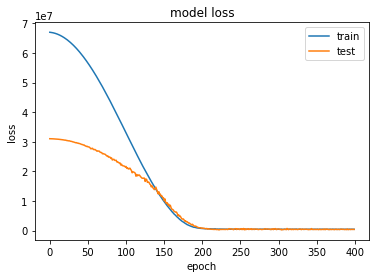

In [1598]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

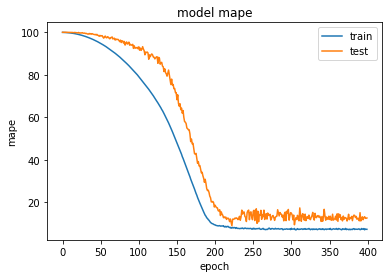

In [1599]:
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('model mape')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

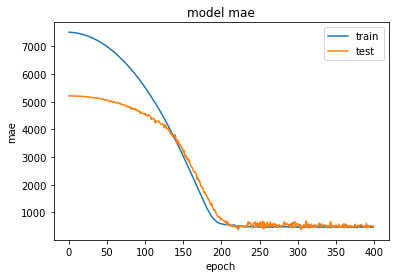

In [1600]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

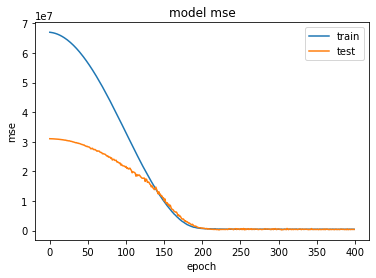

In [1601]:
plt.figure()
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Computing the minimum of the three error measures.

In [1658]:
print('The minimum mean absolute percentage error of the training data is', (np.min(history.history['mape'][150:])))

The minimum mean absolute percentage error of the training data is 6.644664287567139


In [1659]:
print('The minimum mean absolute percentage error of the test data is', (np.min(history.history['val_mape'][150:])))

The minimum mean absolute percentage error of the test data is 9.064825057983398


In [1661]:
print('The minimum mean absolute error of the traning data is', (np.min(history.history['mae'][150:])))

The minimum mean absolute error of the traning data is 435.8214416503906


In [1662]:
print('The minimum mean absolute error of the test  data is', (np.min(history.history['val_mae'][150:])))

The minimum mean absolute error of the test  data is 372.3679504394531


In [1672]:
print('The minimum root mean squared error of the traning data is', np.sqrt(np.min(history.history['mse'][150:])))

The minimum root mean squared error of the traning data is 596.1538444478908


In [1673]:
print('The minimum root mean squared eerror of the test data is', np.sqrt(np.min(history.history['val_mse'][150:])))

The minimum root mean squared eerror of the test data is 439.31190869927485


Clearly performance of the neural network regressor is far inferior to that of the basic persistance algorithm. Curiously, the test error is lower than the training error by some metrics. This is perhaps related to the dropout regularization.

## Neural Network Forecasting of the Returns Data

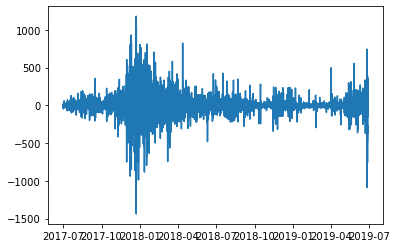

In [1608]:
plt.plot(diff)

In [1609]:
diff.head()

Date
2017-07-01 12:00:00   -16.90
2017-07-01 13:00:00   -33.53
2017-07-01 14:00:00     4.55
2017-07-01 15:00:00     8.85
2017-07-01 16:00:00    -1.39
Name: Close, dtype: float64

In [1610]:
diff2 = series_to_supervised(data, WINDOW)
X= diff2[:,:WINDOW-1]

print(X)
print(X.shape)

[[ 2494.87  2477.97  2444.44 ...  2406.26  2433.    2448.  ]
 [ 2477.97  2444.44  2448.99 ...  2433.    2448.    2470.01]
 [ 2444.44  2448.99  2457.84 ...  2448.    2470.01  2475.  ]
 ...
 [13580.   13456.4  13800.   ... 10830.9  10678.8  10729.  ]
 [13456.4  13800.   13839.   ... 10678.8  10729.   11089.4 ]
 [13800.   13839.   12751.3  ... 10729.   11089.4  11148.  ]]
(17408, 30)


In [1611]:
Y= diff2[:,WINDOW]
Y= Y[:,None]
print(Y)
print(Y.shape)

[[ 2475.  ]
 [ 2482.94]
 [ 2488.59]
 ...
 [11148.  ]
 [11468.6 ]
 [11478.4 ]]
(17408, 1)


In [1612]:
X = np.where(np.isnan(X), ma.array(X, mask=np.isnan(X)).mean(axis=0), X)

In [1613]:
Y = np.where(np.isnan(Y), ma.array(Y, mask=np.isnan(Y)).mean(axis=0), Y)

In [1614]:
train_X = X[:int((len(X)+1)*.66)] 
test_X = X[int(len(X)*.66+1):] 

In [1615]:
len(train_X)

11489

In [1616]:
len(test_X)

5918

In [1617]:
train_Y = Y[:int((len(Y)+1)*.66)] 
test_Y = Y[int(len(Y)*.66+1):] 

In [1618]:
len(test_Y)

5918

In [1619]:
len(train_Y)

11489

In [1620]:
#norm = MinMaxScaler().fit(train_X)
norm = StandardScaler().fit(train_X)

In [1621]:
X_train = norm.transform(train_X)

X_test = norm.transform(test_X)

In [1622]:
Y_train = train_Y
Y_test =  test_Y

In [1623]:
X_train.shape, X_test.shape
X_train

array([[-1.53642481, -1.54186412, -1.55240828, ..., -1.5707812 ,
        -1.56282408, -1.55847485],
       [-1.54160896, -1.5521506 , -1.55101228, ..., -1.56255606,
        -1.55820965, -1.55170326],
       [-1.55189444, -1.55075473, -1.54829697, ..., -1.55794211,
        -1.55143875, -1.55016804],
       ...,
       [-0.33473589, -0.33496504, -0.34099366, ..., -0.32364878,
        -0.33089593, -0.3311904 ],
       [-0.33482791, -0.3408553 , -0.33758802, ..., -0.33075427,
        -0.33104975, -0.33337478],
       [-0.3407176 , -0.33744999, -0.33823233, ..., -0.33090807,
        -0.33323391, -0.33312866]])

In [1624]:
X_test

array([[-0.33795681, -0.3384317 , -0.33939823, ..., -0.33284593,
        -0.33360306, -0.33192878],
       [-0.33829424, -0.33926002, -0.33884596, ..., -0.33346112,
        -0.33178806, -0.33494385],
       [-0.33912247, -0.33870781, -0.34378568, ..., -0.3316463 ,
        -0.33480281, -0.33112887],
       ...,
       [ 1.8639877 ,  1.82614707,  1.93164368, ...,  1.02061037,
         0.97381706,  0.98925334],
       [ 1.82607285,  1.93155819,  1.94360945, ...,  0.97382491,
         0.98926   ,  1.10013382],
       [ 1.93147367,  1.94352278,  1.60988717, ...,  0.98926626,
         1.10012922,  1.11816266]])

In [1625]:
Y_train.shape, Y_test.shape

((11489, 1), (5918, 1))

In [1626]:
history = model.fit(X_train, Y_train, 
          epochs = 400, 
          batch_size = 128, 
          verbose=0, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          )


Epoch 00001: val_loss did not improve from 198159.81250

Epoch 00002: val_loss did not improve from 198159.81250

Epoch 00003: val_loss did not improve from 198159.81250

Epoch 00004: val_loss did not improve from 198159.81250

Epoch 00005: val_loss did not improve from 198159.81250

Epoch 00006: val_loss did not improve from 198159.81250

Epoch 00007: val_loss did not improve from 198159.81250

Epoch 00008: val_loss did not improve from 198159.81250

Epoch 00009: val_loss did not improve from 198159.81250

Epoch 00010: val_loss did not improve from 198159.81250

Epoch 00011: val_loss did not improve from 198159.81250

Epoch 00012: val_loss did not improve from 198159.81250

Epoch 00013: val_loss did not improve from 198159.81250

Epoch 00014: val_loss did not improve from 198159.81250

Epoch 00015: val_loss did not improve from 198159.81250

Epoch 00016: val_loss did not improve from 198159.81250

Epoch 00017: val_loss did not improve from 198159.81250

Epoch 00018: val_loss did not 


Epoch 00139: val_loss did not improve from 198159.81250

Epoch 00140: val_loss did not improve from 198159.81250

Epoch 00141: val_loss did not improve from 198159.81250

Epoch 00142: val_loss did not improve from 198159.81250

Epoch 00143: val_loss did not improve from 198159.81250

Epoch 00144: val_loss did not improve from 198159.81250

Epoch 00145: val_loss did not improve from 198159.81250

Epoch 00146: val_loss did not improve from 198159.81250

Epoch 00147: val_loss did not improve from 198159.81250

Epoch 00148: val_loss did not improve from 198159.81250

Epoch 00149: val_loss did not improve from 198159.81250

Epoch 00150: val_loss did not improve from 198159.81250

Epoch 00151: val_loss did not improve from 198159.81250

Epoch 00152: val_loss did not improve from 198159.81250

Epoch 00153: val_loss did not improve from 198159.81250

Epoch 00154: val_loss did not improve from 198159.81250

Epoch 00155: val_loss did not improve from 198159.81250

Epoch 00156: val_loss did not 


Epoch 00276: val_loss did not improve from 198159.81250

Epoch 00277: val_loss did not improve from 198159.81250

Epoch 00278: val_loss did not improve from 198159.81250

Epoch 00279: val_loss did not improve from 198159.81250

Epoch 00280: val_loss did not improve from 198159.81250

Epoch 00281: val_loss did not improve from 198159.81250

Epoch 00282: val_loss did not improve from 198159.81250

Epoch 00283: val_loss did not improve from 198159.81250

Epoch 00284: val_loss did not improve from 198159.81250

Epoch 00285: ReduceLROnPlateau reducing learning rate to 0.00015009464841568844.

Epoch 00285: val_loss did not improve from 198159.81250

Epoch 00286: val_loss did not improve from 198159.81250

Epoch 00287: val_loss did not improve from 198159.81250

Epoch 00288: val_loss did not improve from 198159.81250

Epoch 00289: val_loss did not improve from 198159.81250

Epoch 00290: val_loss did not improve from 198159.81250

Epoch 00291: val_loss did not improve from 198159.81250

Epoch

Plotting graphs of the model less as well as three different measures: MAPE, MAE and MSE.

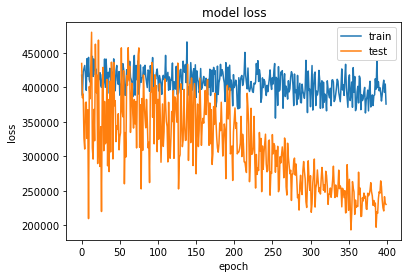

In [1627]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

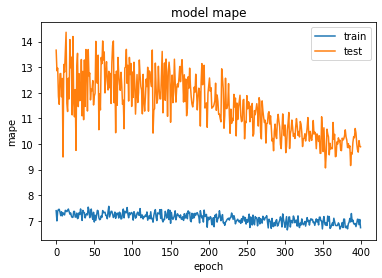

In [1628]:
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('model mape')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

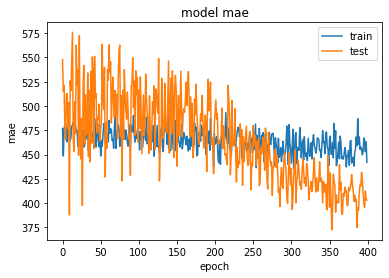

In [1629]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

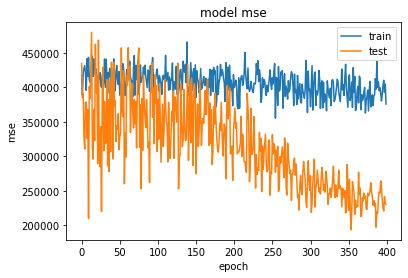

In [1630]:
plt.figure()
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Computing the minimum of the three error measures.

In [1666]:
print('The minimum mean absolute percentage error of the training data is', (np.min(history.history['mape'][150:])))

The minimum mean absolute percentage error of the training data is 6.644664287567139


In [1667]:
print('The minimum mean absolute percentage error of the test data is', (np.min(history.history['val_mape'][150:])))

The minimum mean absolute percentage error of the test data is 9.064825057983398


In [1668]:
print('The minimum mean absolute error of the training data is', (np.min(history.history['mae'][150:])))

The minimum mean absolute error of the training data is 435.8214416503906


In [1669]:
print('The minimum mean absolute error of the test data is', (np.min(history.history['val_mae'][150:])))

The minimum mean absolute error of the test data is 372.3679504394531


In [1670]:
print('The minimum root mean square error of the training data is', np.sqrt(np.min(history.history['mse'][150:])))

The minimum root mean square error of the training data is 596.1538444478908


In [1671]:
print('The minimum root mean square error of the test  data is', np.sqrt(np.min(history.history['val_mse'][150:])))

The minimum root mean square error of the test  data is 439.31190869927485


The best regression performance of the return time series is about the same as the raw data. Though the time series is now trend stationary it seems the differencing operation has removed the memory as well thus greatly impacting predictability.

## Results and Discussion

The neural network forecasts for the raw Bitcoin time series were very poor - worse even than the very simple persistance forecast. This is unsurprising given the disjointed nature of the time series. More sophisticated features than the raw time series such as technical indicators may give better forecasting accuracy. The time series of the returns gave an equally bad forecast which is clearly a consequence of most of the memory in the time series  being removed by the first differencing, as evidinced by its autocorrelation function. It would be interesting to compare the performances of the first differenced time series with a fractionally differenced time series.  Fractional differencing of a time series only removes the bare minimum of the nonstationary while preserving much of the memory and hence predictability in a time series.

In finance we are often only interested in predicting price increases or decreases in a time series rather than the actual value. This is a classification rather than a pure regression problem. This will be the subject of the next part of the project.

## 